In [1]:
#!pip install pathos
#!pip install pymoo
#!pip install pymop

In [2]:

import time
import pandas as pd
import os,sys
import numpy as np

print(os.path.dirname(os.path.abspath('../')),sys.path)
sys.path.append(os.path.dirname(os.path.abspath('../')))

# NSGAIII
from pearlmoo.methods.constr_nsgaIII import constrNSGAIII


c:\Users\SEURPR\OneDrive - Idaho National Laboratory\Desktop\LDRD\LDRD microreactor performance\For_release\PEARL-MOOv1\PEARL-MOO ['c:\\Users\\SEURPR\\OneDrive - Idaho National Laboratory\\Desktop\\LDRD\\LDRD microreactor performance\\For_release\\PEARL-MOOv1\\PEARL-MOO\\examples\\constrained_optimization', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\python37.zip', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\DLLs', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl', '', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib\\site-packages', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib\\site-packages\\win32', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib\\site-packages\\win32\\lib', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib\\site-packages\\Pythonwin', 'c:\\Users\\SEURPR\\AppData\\Local\\anaconda3\\envs\\neorl\\lib\

In [3]:
from pearlmoo.utils.tools import uniform_reference_points # used to generate approprietaly spaced pareto front
from pearlmoo.utils.tools import isDominated
from pearlmoo.utils.hyper_volume import hypervolume

In [4]:
# Quickstart
# ---
from math import factorial
# Generate a multi-objective optimization problem from pymop
from pymop.factory import get_problem
PROBLEM = 'c2dtlz2'
NOBJ = 3
K = 5
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
MU = int(H + (4 - H % 4))
lambda_ = MU
# create the reference directions to be used for the optimization
problem = get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)
ref_points = uniform_reference_points(nobj = NOBJ, p = P)
pf = problem.pareto_front(ref_points)
# Generate bounds
BOUND_LOW, BOUND_UP = 0.0,1.0
nx=NDIM
BOUNDS={}
for i in range(1,nx+1):
    BOUNDS['x'+str(i)]=['float', BOUND_LOW, BOUND_UP]

def fitness_wrapper(*args, **kwargs):
    """
    Modify classical output of the form F,CV to dict read by constrained Mmulti-objective versions
    {'objectives':F,'constraints':CV}
    """
    fitness = problem.evaluate(*args, **kwargs)# objective function
    return {"objectives":fitness[0],"constraints":fitness[1]}# the optimizer accept a dictionary

# Create NSGAIII environment and run it
nsgaiii=constrNSGAIII(mode='min', bounds=BOUNDS, fit=fitness_wrapper, mu = lambda_,lambda_=lambda_, mutpb=0.1,alpha=0.5,smin=0.00, smax=0.50,
                         cxmode='blend', cxpb=0.8, sorting = 'log',paradigm = "constrained",ncores=1)

x_bestnsgaIII, y_bestnsgaIII, run_typ_hist=nsgaiii.evolute(ngen=130, verbose=0)#,x0=x0)
                                        

--- :
Pareto Optimal solutions: 81
Unique Pareto Optimal solutions (69, 3)
nadir [-1.504094e-17 -0.000000e+00 -0.000000e+00]
hyper volume  26.316925492584044


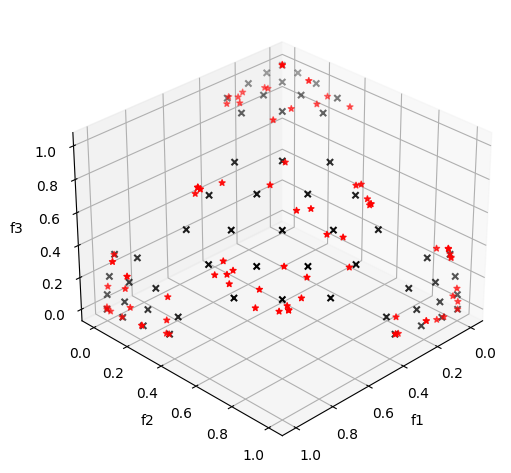

In [5]:
sol = [] # Check which elemnt of MOSA result are dominated:
for_hv = []
X = []
Y = []
Z = []
for elem in run_typ_hist['global_fitness']:
    isdominated = False
    G = elem[-1]
    elem = elem[:-1]  
    if G == 0:# only add if feasible
        for_hv.append(elem)
        for elem2 in pf:
            if isDominated(-elem,-elem2):
                isdominated = True
        if not isdominated:
            sol.append(elem)

print("--- :")
print("Pareto Optimal solutions:",len(sol))
nsgaiii_sol = np.unique(sol,axis=0)
print('Unique Pareto Optimal solutions',nsgaiii_sol.shape)

if for_hv == []:
    HV = 0
else:
    nadir = np.max([[-np.array(x) for x in for_hv]],axis=1)[0]
    print("nadir",nadir)
    HV = hypervolume(np.array(for_hv), np.array([3,3,3]))
    print('hyper volume ',HV)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(run_typ_hist["global_fitness"])[:,0],np.array(run_typ_hist["global_fitness"])[:,1],np.array(run_typ_hist["global_fitness"])[:,2], marker = '*',color = 'red')
ax.scatter(np.array(pf)[:,0],np.array(pf)[:,1],np.array(pf)[:,2], marker = 'x',color = 'black')
ax.view_init(elev=30, azim=45)
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('f3')
plt.tight_layout()